Mounted at /content/drive
Round 1:
Global model validation loss: 2.3031, accuracy: 0.0974
Round 2:
Global model validation loss: 2.3031, accuracy: 0.0972
Round 3:
Global model validation loss: 2.3030, accuracy: 0.0975
Round 4:
Global model validation loss: 2.3030, accuracy: 0.0976
Round 5:
Global model validation loss: 2.3031, accuracy: 0.0973
Round 6:
Global model validation loss: 2.3031, accuracy: 0.0973
Round 7:
Global model validation loss: 2.3031, accuracy: 0.0973
Round 8:
Global model validation loss: 2.3030, accuracy: 0.0976
Round 9:
Global model validation loss: 2.3030, accuracy: 0.0974
Round 10:
Global model validation loss: 2.3031, accuracy: 0.0973
Round 11:
Global model validation loss: 2.3031, accuracy: 0.0974
Round 12:
Global model validation loss: 2.3031, accuracy: 0.0973
Round 13:
Global model validation loss: 2.3030, accuracy: 0.0974
Round 14:
Global model validation loss: 2.3031, accuracy: 0.0974
Round 15:
Global model validation loss: 2.3031, accuracy: 0.0972
Round 16

ValueError: ignored

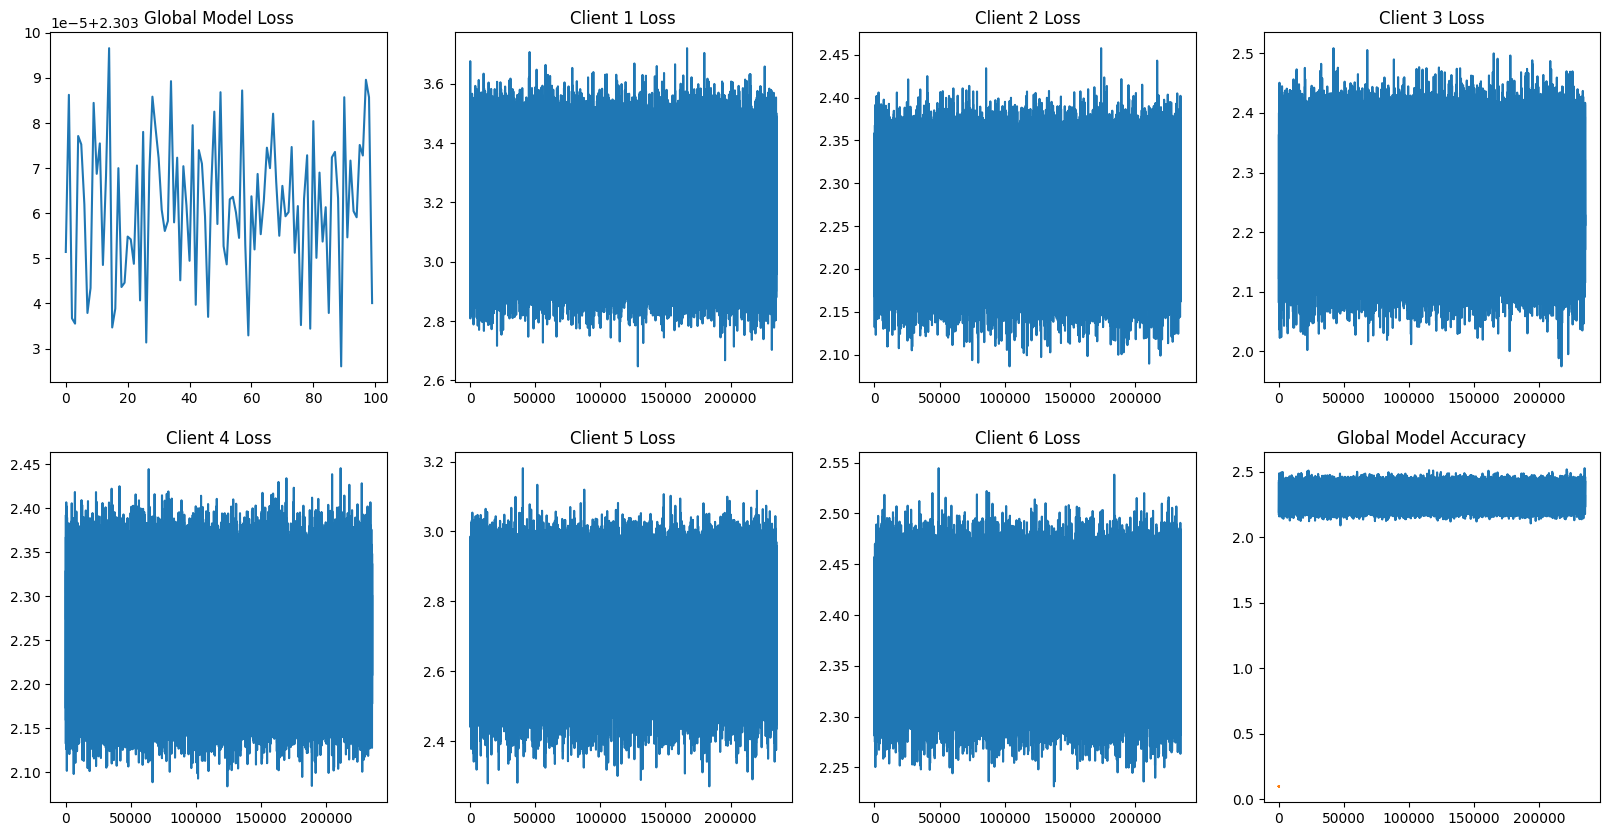

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive'
train_path = path + '/mnist_train.csv'
valid_path = path + '/mnist_test.csv'

train_data = pd.read_csv(train_path)
valid_data = pd.read_csv(valid_path)
train_data = train_data.values
valid_data = valid_data.values
train_label = train_data[:,0]
train_data = train_data[:,1:]
valid_label = valid_data[:,0]
valid_data = valid_data[:,1:]

sorted_idx = np.argsort(train_label)
train_data = train_data[sorted_idx]
train_label = train_label[sorted_idx]

num_clients = 7
data_per_client = len(train_data) // num_clients
class ClientDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float)
        y = torch.tensor(int(self.label[idx]), dtype=torch.long)
        return x, y

data_clients = []

for i in range(num_clients):
    start = i * data_per_client
    end = start + data_per_client
    data_client = train_data[start:end]
    label_client = train_label[start:end]
    dataset = ClientDataset(data_client, label_client)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    client = {
        'dataset': dataset,
        'data_loader': data_loader
    }
    data_clients.append(client)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.reshape(-1,28*28)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x =F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

global_model = Net().to(device)
client_models = [Net().to(device) for i in range(num_clients)]

def FedAvg(client_models):
    global_params = global_model.state_dict()
    client_params = {}
    for i in range(num_clients):
        client_params[i] = client_models[i].state_dict()
    for param in global_params:
        global_params[param] = torch.mean(torch.stack([client_params[i][param] for i in range(num_clients)], dim=0), dim=0)
    global_model.load_state_dict(global_params)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(global_model.parameters(), lr=0.01)

num_rounds = 100
client_epochs = [1, 5, 20]
global_loss = []
global_acc = []
client_loss = [[] for i in range(num_clients)]
client_acc = [[] for i in range(num_clients)]

for r in range(num_rounds):
    print(f"Round {r+1}:")
    for i in range(num_clients):
        if r < 33:
            epochs = client_epochs[0]
        elif r < 66:
            epochs = client_epochs[1]
        else:
            epochs = client_epochs[2]
        for e in range(epochs):
            client_models[i].train()
            for batch_idx, (data, target) in enumerate(data_clients[i]['data_loader']):
                data, target = data.to(device), target.to(device)
                client_models[i].zero_grad()
                output = client_models[i](data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                client_loss[i].append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                correct = pred.eq(target.view_as(pred)).sum().item()
                acc = correct / len(data)
                client_acc[i].append(acc)
    FedAvg(client_models)
    global_model.eval()
    valid_dataset = ClientDataset(valid_data, valid_label)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            valid_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            valid_acc += correct / len(data)
    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)
    global_loss.append(valid_loss)
    global_acc.append(valid_acc)
    print(f"Global model validation loss: {valid_loss:.4f}, accuracy: {valid_acc:.4f}")

plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.plot(global_acc)
plt.title("Global Model Accuracy")
for i in range(num_clients):
    plt.subplot(2, 4, i+2)
    plt.plot(client_acc[i])
    plt.title(f"Client {i+1} Accuracy")
plt.show()



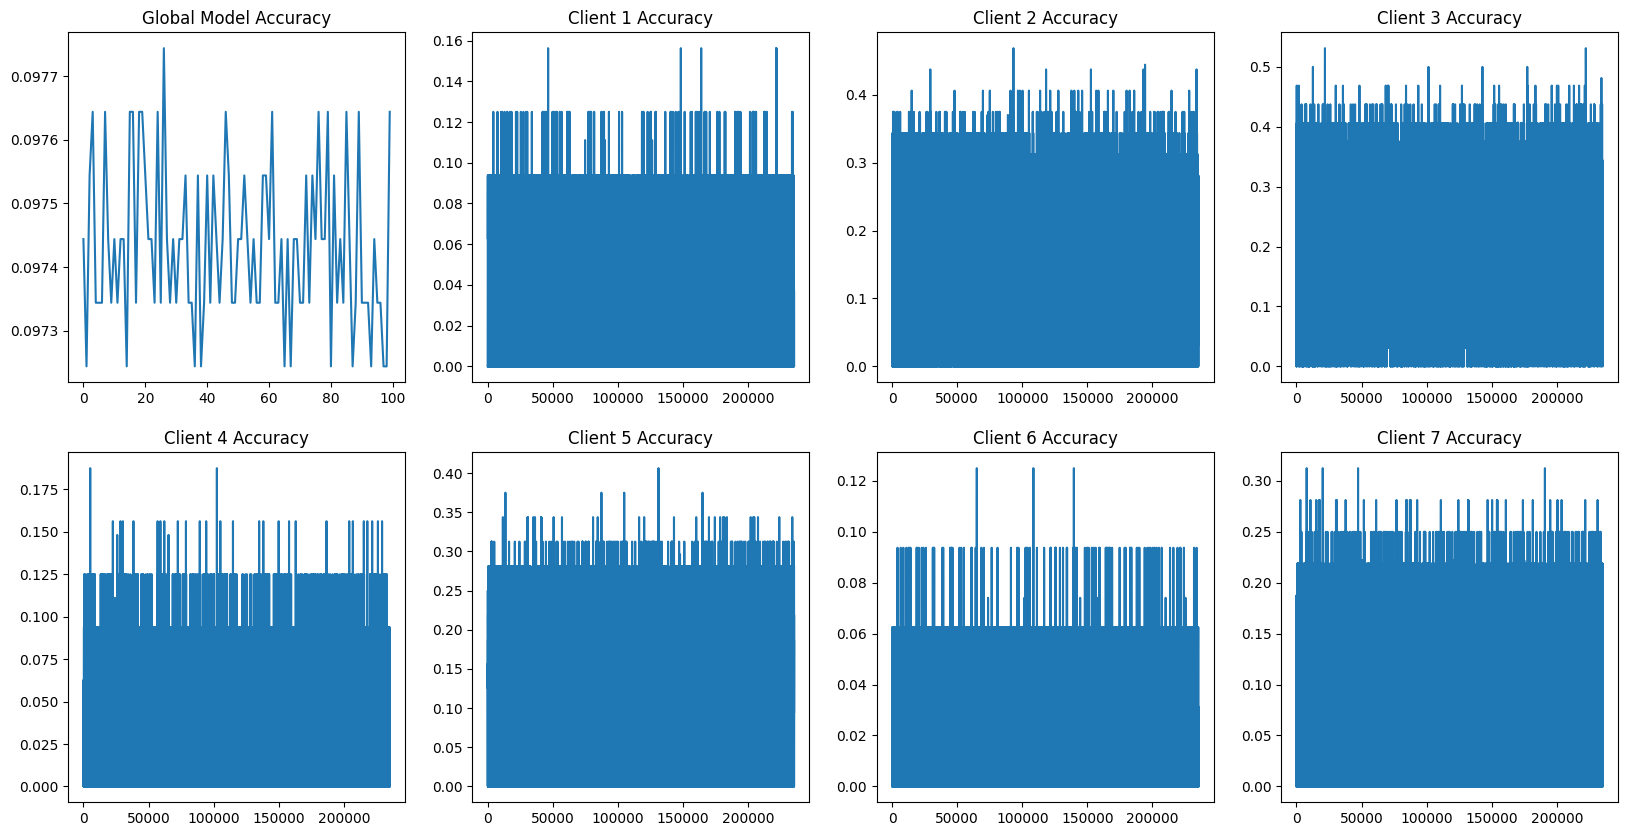

In [8]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 4, 1)
plt.plot(global_acc)
plt.title("Global Model Accuracy")
for i in range(num_clients):
    plt.subplot(2, 4, i+2)
    plt.plot(client_acc[i])
    plt.title(f"Client {i+1} Accuracy")
plt.show()

